In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir data
!cp drive/MyDrive/'archive (2).zip' data/
!unzip data/'archive (2).zip' -d data/

In [ ]:
class_to_idx = {'palazzos': 0,
 'blouse': 1,
 'saree': 2,
 'lehenga': 3,
 'gowns': 4,
 'sherwanis': 5,
 'women_kurta': 6,
 'nehru_jackets': 7,
 'leggings_and_salwars': 8,
 'dupattas': 9,
 'mojaris_men': 10,
 'kurta_men': 11,
 'dhoti_pants': 12,
 'petticoats': 13,
 'mojaris_women': 14}

In [ ]:
import json
import numpy as np
from PIL import Image

# json_path = '/kaggle/input/indo-fashion-dataset/train_data.json'
# image_path = '/kaggle/input/indo-fashion-dataset/images/train/'

train_json_path = 'data/train_data.json'
train_image_path = 'data/images/train/'

valid_json_path = 'data/val_data.json'
valid_image_path = 'data/images/val/'

test_json_path = 'data/test_data.json'
test_image_path = 'data/images/test/'

def gather_image_caption_dict(json_path, image_path):
		input_data_im_cl = []
		labels = []
		import time
		st = time.time()
		ctr=0
		with open(json_path, 'r') as f:
			for line in f:
				obj = json.loads(line)
				tmp = {'image': 'data/'+obj['image_path'],
									'caption': obj['class_label']}
				input_data_im_cl.append(tmp)
		# 		if ctr%100==0:
		# 			print(f"CTR : {ctr}", end="\r", flush=True)
		# 		ctr+=1

		et = time.time()
		print(f'Time Taken: {et-st}')
		return input_data_im_cl

In [ ]:
train_input_data_im_cl = gather_image_caption_dict(train_json_path, train_image_path)
val_input_data_im_cl = gather_image_caption_dict(valid_json_path, valid_image_path)
test_input_data_im_cl = gather_image_caption_dict(test_json_path, test_image_path)

Time Taken: 0.7974340915679932
Time Taken: 0.048651695251464844
Time Taken: 0.05334949493408203


In [ ]:
def check_im_size(image_path):
    if np.array(Image.open(image_path)).size<1000:
        return False
    else:
        return True


In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# Number of workers (threads); you can adjust this based on your task and system capabilities
num_workers = 4
train_inputs = [x['image'] for x in train_input_data_im_cl]
valid_inputs = [x['image'] for x in val_input_data_im_cl]
test_inputs = [x['image'] for x in test_input_data_im_cl]

# Use ThreadPoolExecutor to parallelize tasks
with ThreadPoolExecutor(max_workers=num_workers) as executor:
    # Map the worker_task over inputs and wrap with tqdm for progress reporting
    # The results will be in the same order as the inputs
    train_results = list(tqdm(executor.map(check_im_size, train_inputs), total=len(train_inputs)))
    valid_results = list(tqdm(executor.map(check_im_size, valid_inputs), total=len(valid_inputs)))
    test_results  = list(tqdm(executor.map(check_im_size, test_inputs), total=len(test_inputs)))

100%|██████████| 7500/7500 [00:07<00:00, 1035.45it/s]


In [ ]:
train_input_data_im_cl_ref = []
for item, b in zip(train_input_data_im_cl, train_results):
    if b:
        train_input_data_im_cl_ref.append(item)
len(train_input_data_im_cl_ref), len(train_input_data_im_cl)

(91162, 91166)

In [ ]:
valid_input_data_im_cl_ref = []
for item, b in zip(val_input_data_im_cl, valid_results):
    if b:
        valid_input_data_im_cl_ref.append(item)
len(valid_input_data_im_cl_ref), len(val_input_data_im_cl)

(7500, 7500)

In [ ]:
test_input_data_im_cl_ref = []
for item, b in zip(test_input_data_im_cl, test_results):
    if b:
        test_input_data_im_cl_ref.append(item)
len(test_input_data_im_cl_ref), len(test_input_data_im_cl)

(7500, 7500)

In [ ]:
classes = []
for item in train_input_data_im_cl_ref:
    classes.append(item['caption'])

from collections import Counter
Counter(classes)

Counter({'saree': 10791,
         'blouse': 9174,
         'dhoti_pants': 4145,
         'dupattas': 6587,
         'gowns': 5211,
         'kurta_men': 6951,
         'leggings_and_salwars': 7787,
         'lehenga': 5752,
         'mojaris_men': 2546,
         'mojaris_women': 3228,
         'nehru_jackets': 6490,
         'palazzos': 3374,
         'petticoats': 4441,
         'sherwanis': 2991,
         'women_kurta': 11694})

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
train_df = pd.DataFrame(train_input_data_im_cl_ref)
valid_df = pd.DataFrame(valid_input_data_im_cl_ref)
test_df = pd.DataFrame(test_input_data_im_cl_ref)


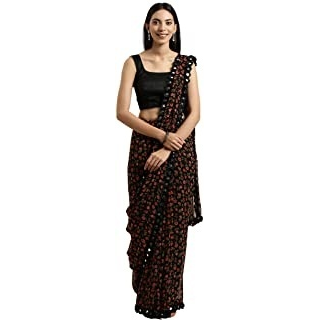

In [ ]:
from PIL import Image

def create_square_layout(image_path, background_color=(255, 255, 255)):
    """
    Create a square layout of the max dimension of the image and place the image on the layout.

    Args:
        image_path (str): Path to the original image.
        background_color (tuple): Background color for the square layout in RGB format. Default is white.

    Returns:
        PIL.Image: The resulting image with a square layout.
    """
    # Load the original image
    image = Image.open(image_path)

    # Determine the size of the new square layout
    max_dim = max(image.size)
    square_layout = Image.new('RGB', (max_dim, max_dim), background_color)

    # Calculate the position to paste the original image on the square layout
    x = (max_dim - image.size[0]) // 2
    y = (max_dim - image.size[1]) // 2

    # Paste the original image onto the square layout
    square_layout.paste(image, (x, y))

    return square_layout

# Usage example
image_path = train_df['image'].iloc[0]  # Update this to your image path
resulting_image = create_square_layout(image_path, background_color=(255, 255, 255))

# Display the resulting image
resulting_image

# Optionally, save the resulting image
# resulting_image.save("path/to/save/square_layout.jpg")


In [ ]:
from transformers import CLIPProcessor
from torch.utils.data import Dataset, DataLoader
import torch

from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
from torchvision import transforms, models
# Define your model, datasets here
# model = Net(3)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(45),
        transforms.RandomAutocontrast(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        """
        Args:
            image_paths (list): List of paths to the images. Only paths are stored, not the actual images.
            labels (list): List of labels for the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = create_square_layout(image_path, background_color=(255, 255, 255)).convert("RGB")
        #image = Image.open(image_path).convert('RGB')  # Image is loaded here, not in __init__
        label = class_to_idx[self.labels[idx]]

        if self.transform:
            image = self.transform(image)

        return image, label


# Create the dataset
train_dataset = CustomImageDataset(image_paths=train_df['image'].values, labels=train_df['caption'].values,
                                   transform=data_transforms['train'])
valid_dataset = CustomImageDataset(image_paths=valid_df['image'].values, labels=valid_df['caption'].values,
                                   transform=data_transforms['val'])
# test_dataset = CustomImageDataset(image_paths=image_paths, labels=labels,
#                                    transform=data_transforms['test'])


In [ ]:
# train_dict = []
# for x,y in zip(train_df['image'].values, train_df['caption'].values):
#     train_dict.append({'image':x,
#                        'caption':y})

# valid_dict = []
# for x,y in zip(valid_df['image'].values, valid_df['caption'].values):
#     valid_dict.append({'image':x,
#                      'caption':y})

# test_dict = []
# for x,y in zip(test_df['image'].values, test_df['caption'].values):
#     test_dict.append({'image':x,
#                      'caption':y})

In [ ]:
from torch.optim import AdamW
from torch.utils.data import DataLoader
import torch
from PIL import Image
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import StepLR

In [ ]:
# import gc
# del model
# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
from tqdm.notebook import tqdm
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

class Trainer:
    """
    A class used to train and validate a PyTorch model.

    Attributes:
    - device: The device (CPU or CUDA) on which to train the model.
    - model: The neural network model to be trained.
    - train_loader: DataLoader for the training dataset.
    - val_loader: DataLoader for the validation dataset.
    - criterion: Loss function.
    - optimizer: Optimization algorithm.
    - history: Dictionary to store training and validation loss, accuracy, precision, and recall.

    Methods:
    - train_epoch(): Trains the model for one epoch on the training dataset.
    - validate_epoch(): Validates the model on the validation dataset.
    - train(num_epochs): Trains and validates the model for a specified number of epochs.
    - epoch_end(epoch, train_loss, val_loss, accuracy, precision, recall): Prints metrics at the end of an epoch.
    - plot_metrics(): Plots the training history including loss and accuracy metrics.
    """

    def __init__(self, model, train_dataset, val_dataset, batch_size=32, learning_rate=1e-3,
                 dataloader_kwargs=None, small_dataset = False, step_lr_factor=0.05,
                 step_lr_patience=3):
        """
        Initializes the Trainer class with the model, datasets, batch size, learning rate, and DataLoader parameters.

        Parameters:
        - model: The model to train.
        - train_dataset: The dataset used for training.
        - val_dataset: The dataset used for validation.
        - batch_size: The size of batches for training and validation (default is 32).
        - learning_rate: The learning rate for the optimizer (default is 1e-3).
        - **dataloader_kwargs: Additional keyword arguments for the DataLoader instances.
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        # Modify DataLoader instantiation to accept additional keyword arguments
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **dataloader_kwargs)
        self.val_loader = DataLoader(val_dataset, batch_size=batch_size, **dataloader_kwargs)
        self.criterion = nn.CrossEntropyLoss()
        if small_dataset:
            self.optimizer = optim.AdamW(self.model.fc.parameters(), lr=learning_rate)  # Only optimize the final layer
        else:
            self.optimizer = optim.AdamW(self.model.parameters(), lr=learning_rate)

        self.history = {'train_loss': [], 'val_loss': [], 'accuracy': [], 'precision': [], 'recall': []}
        # Setup the learning rate scheduler
        #self.scheduler = ReduceLROnPlateau(self.optimizer, 'min', factor=0.1, patience=5, verbose=True)
        self.step_lr_factor=step_lr_factor
        self.step_lr_patience=step_lr_patience
        self.scheduler = ReduceLROnPlateau(self.optimizer, 'min',
                                           factor=step_lr_factor, patience=step_lr_patience,
                                           verbose=True)



    def train_epoch(self):
        """Trains the model for one epoch over the training dataset."""
        self.model.train()  # Set the model to training mode
        total_loss = 0
        for images, labels in tqdm(self.train_loader, total=len(self.train_loader)):
            images, labels = images.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()  # Clear gradients
            outputs = self.model(images)  # Forward pass
            loss = self.criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            self.optimizer.step()  # Update model parameters

            total_loss += loss.item()  # Accumulate loss
        avg_loss = total_loss / len(self.train_loader)  # Calculate average loss
        return avg_loss

    def validate_epoch(self):
        """Validates the model on the validation dataset."""
        self.model.eval()  # Set the model to evaluation mode
        total_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():  # Disable gradient computation
            for images, labels in tqdm(self.val_loader, total=len(self.val_loader)):
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                total_loss += loss.item()
                _, preds = torch.max(outputs, 1)  # Get the predicted classes
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate metrics
        avg_loss = total_loss / len(self.val_loader)
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        return avg_loss, accuracy, precision, recall

    def train(self, num_epochs):
        """Trains and validates the model for a specified number of epochs."""
        for epoch in range(num_epochs):
            if epoch==1:
                for param in self.model.parameters():
                    param.requires_grad = True
            train_loss = self.train_epoch()  # Train for one epoch
            val_loss, accuracy, precision, recall = self.validate_epoch()  # Validate
            # Update history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['accuracy'].append(accuracy)
            self.history['precision'].append(precision)
            self.history['recall'].append(recall)
            # Print metrics for the epoch
            self.epoch_end(epoch, train_loss, val_loss, accuracy, precision, recall)

            # Scheduler step with validation loss
            self.scheduler.step(val_loss)

    def epoch_end(self, epoch, train_loss, val_loss, accuracy, precision, recall):
        """Prints the metrics at the end of an epoch."""
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

    def plot_metrics(self):
        """Plots the training and validation loss, accuracy, precision, and recall over epochs."""
        epochs = range(len(self.history['train_loss']))
        plt.figure(figsize=(10, 6))
        plt.subplot(2, 2, 1)
        plt.plot(epochs, self.history['train_loss'], label='Training Loss')
        plt.plot(epochs, self.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(epochs, self.history['accuracy'], label='Accuracy')
        plt.plot(epochs, self.history['precision'], label='Precision')
        plt.plot(epochs, self.history['recall'], label='Recall')
        plt.title('Accuracy, Precision, and Recall')
        plt.legend()
        plt.show()


In [ ]:
!pip install timm -q

In [ ]:
import timm
# Load a pre-trained ResNet18 model
#model = timm.create_model('efficientnet_v2_s', pretrained=True)
model = models.efficientnet.efficientnet_b1(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# Update the final fully connected layer if the number of classes is different
# For example, for CIFAR-10, we have 10 classes
#num_ftrs = model.fc.in_features
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 15)

if torch.cuda.device_count() > 1:
    print(f"Let's use {torch.cuda.device_count()} GPUs!")
    # Wrap the model with nn.DataParallel
    model = nn.DataParallel(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
cuda_kwargs = {'num_workers': 4,
               'pin_memory': True}

trainer = Trainer(model, train_dataset, valid_dataset, batch_size=96, learning_rate=1e-3,
                  dataloader_kwargs=cuda_kwargs)
trainer.train(num_epochs=30)
trainer.plot_metrics()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0, Train Loss: 1.1721, Validation Loss: 0.9584, Accuracy: 0.6883, Precision: 0.7239, Recall: 0.6883


  0%|          | 0/950 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.5065, Validation Loss: 0.4254, Accuracy: 0.8572, Precision: 0.8735, Recall: 0.8572


  0%|          | 0/950 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.3847, Validation Loss: 0.4089, Accuracy: 0.8703, Precision: 0.8764, Recall: 0.8703


  0%|          | 0/950 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.3548, Validation Loss: 0.3590, Accuracy: 0.8841, Precision: 0.8885, Recall: 0.8841


  0%|          | 0/950 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.3309, Validation Loss: 0.3822, Accuracy: 0.8792, Precision: 0.8902, Recall: 0.8792


  0%|          | 0/950 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.3169, Validation Loss: 0.3618, Accuracy: 0.8820, Precision: 0.8927, Recall: 0.8820


  0%|          | 0/950 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.3014, Validation Loss: 0.3690, Accuracy: 0.8801, Precision: 0.8888, Recall: 0.8801


  0%|          | 0/950 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.2899, Validation Loss: 0.3649, Accuracy: 0.8877, Precision: 0.8972, Recall: 0.8877
Epoch 00008: reducing learning rate of group 0 to 5.0000e-05.


  0%|          | 0/950 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.2285, Validation Loss: 0.3178, Accuracy: 0.9017, Precision: 0.9087, Recall: 0.9017


  0%|          | 0/950 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.2093, Validation Loss: 0.3117, Accuracy: 0.9019, Precision: 0.9086, Recall: 0.9019


  0%|          | 0/950 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10, Train Loss: 0.1992, Validation Loss: 0.3114, Accuracy: 0.9020, Precision: 0.9085, Recall: 0.9020


  0%|          | 0/950 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# for param in model.parameters():
#     param.requires_grad = True
# trainer = Trainer(trainer.model, train_dataset, valid_dataset, batch_size=128, learning_rate=1e-4,
#                   dataloader_kwargs=cuda_kwargs, step_lr_factor=0.5, step_lr_patience=3)
# trainer.train(num_epochs=30)
# trainer.plot_metrics()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/713 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 28.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 11.06 MiB is free. Process 117715 has 14.73 GiB memory in use. Of the allocated memory 14.18 GiB is allocated by PyTorch, and 421.22 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# import gc
# del model
# gc.collect()
# torch.cuda.empty_cache()